### Libraries Requirements

In [1]:
# !pip3 install -r requirements.txt

In [2]:
import pandas as pd 
import numpy as np 
import random
import json
from copy import deepcopy

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

import pickle
from sklearn.metrics import precision_score, accuracy_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, recall_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
def prepare_data(data, data_info, shuffle=True):
    """Preprocesses the input data.

    Args:
        data (list): List of pandas DataFrames to be concatenated.
        data_info (dict): Information about the data setup.
        shuffle (bool, optional): Whether to shuffle the data. Defaults to True.

    Returns:
        pandas.DataFrame: Preprocessed dataset.
    """
    df = pd.concat([df for df in data])
    ad_sets = df[data_info["groups"]].unique()
    np.random.shuffle(ad_sets)

    if shuffle:
        dataset = pd.DataFrame(columns=df.columns)
        for ad in ad_sets:
            ad_df = df[df[data_info["groups"]] == ad].sort_values(data_info["sort_by"])
            dataset = pd.concat([dataset, ad_df])

        dtypes = df.dtypes
        dataset = dataset.astype(dtypes)
    else:
        dataset = df.copy()

    dataset = dataset.reset_index(drop=True)
    return dataset

def load_model_parameters(load_path="./models/model_parameters.pkl"):
    """Load trained model parameters from a file."""
    with open(load_path, "rb") as file:
        models = pickle.load(file)
    return models

In [4]:
with open('config.json', 'r') as f:
    config_data = json.load(f)

PROCESSING_INFO = config_data['PROCESSING_INFO']
TRAIN_INFO = config_data['TRAIN_INFO']

In [5]:
PATHS = [
    "15-17.02.2024.csv"
]

DATA = [pd.read_csv(f"./processed/{path}") for path in PATHS]
MODEL = load_model_parameters()["Gradient Boosting"]

In [6]:
class Action:
    """Represents an action with successes and failures, supporting Bayesian updates."""
    def __init__(self, successes=1, failures=1):
        self.successes = successes
        self.failures = failures

    def sample(self, num_samples=1):
        """Samples from the Beta distribution defined by the action's successes and failures."""
        beta_samples = np.random.beta(self.successes, self.failures, size=num_samples)
        if num_samples == 1:
            return beta_samples[0]    
        return beta_samples

    def update(self, success, failure):
        """Updates the action's successes and failures."""
        self.successes += success
        self.failures += failure

    def get_parameters(self):
        """Returns the current successes and failures."""
        return self.successes, self.failures

    def __str__(self):
        """Returns a string representation of the action."""
        return f"Action(s={self.successes}, f={self.failures})"


class AdSet:
    """Represents a set of advertisement data with associated Action instance."""
    def __init__(self, successful, data, action):
        self.data = data.reset_index(drop=True)
        self._successful = successful
        self._record = 0
        self.action = action
        self.spend = 0

    def get_record(self):
        """Retrieves the current advertisement metrics record for adset performance evaluation."""
        record = self.data.iloc[self._record, :]
        self._record += 1
        return record

    def __str__(self):
        """Provides a string representation of the AdSet"""
        return f"AdSet(successful={self._successful}, record={self._record})"

In [7]:
def binarize(record, model=MODEL, train_info=TRAIN_INFO):
    """
    Converts a record or multiple records into a binary format based on the model's prediction.
    
    Args:
        record (pd.Series or pd.DataFrame): The input data to be binarized. 
        Can be a single record (pd.Series) or multiple records (pd.DataFrame).
        model (Model): The predictive model used for binarization. Must have a predict method that accepts numpy arrays.
        train_info (dict): A dictionary containing training information. 
        Must include a key "train_fields" that specifies the fields in the record to be used by the model.
    
    Returns:
        int or np.ndarray: The predicted binary outcome(s).
    """
    if record.ndim == 1:
        context = record.loc[train_info["train_fields"]].to_numpy().reshape(1, -1)
        return model.predict(context)[0]
    elif record.ndim == 2:
        context = record.loc[:, train_info["train_fields"]].to_numpy()
        return model.predict(context)   
    else:
        return None

In [8]:
data = prepare_data(DATA, TRAIN_INFO)
max_timestamps = data.groupby(TRAIN_INFO["groups"])["hour"].count().max()

def simulate_ad_set_performance(data, train_info, max_timestamps, baseline=0.68, ngood=None, nbad=None, gather_choices=False):
    """
    Simulates the performance of ad sets based on provided data and training information.

    Args:
        data (pd.DataFrame): The input data containing information about ad groups and their performance.
        train_info (dict): A dictionary containing training information, including label field and group identifiers.
        max_timestamps (int): The maximum number of timestamps to simulate.
        baseline (float): The baseline success probability threshold for considering an action successful.
        ngood (int): Number of good ad groups to sample for simulation.
        nbad (int): Number of bad ad groups to sample for simulation.
        gather_choices (bool): If True, gather the choices made during the simulation.

    Returns:
        tuple: A tuple containing simulation history, ad sets, and regret values.
            - history (dict): A dictionary containing information about ad sets at different timestamps.
                              Each key represents a timestamp, and the corresponding value is a list of ad sets.
                              Each ad set is an object containing information about its actions and success.
            - adsets (list): A list of ad sets used in the simulation.
            - regret (list): A list containing regret values at each timestamp during the simulation.
    """
    test_field = train_info["label_field"]
    groups = train_info["groups"]

    if ngood is None:
        ngood = data[data[test_field] == 1][groups].nunique()
    if nbad is None:
        nbad = data[data[test_field] == 0][groups].nunique()

    good_groups = random.sample(sorted(data[data[test_field] == 1][groups].unique()), ngood)
    bad_groups = random.sample(sorted(data[data[test_field] == 0][groups].unique()), nbad)

    adsets = []
    regret = []

    for ad in bad_groups:
        adset = AdSet(0, data[data[groups] == ad], Action())
        adsets.append(adset)

    for ad in good_groups:
        adset = AdSet(1, data[data[groups] == ad], Action())
        adsets.append(adset)

    history = {}

    for timestamp in range(max_timestamps):
        current_reward = 0
        current_optimal_reward = 0
        history[timestamp] = deepcopy(adsets)

        for ad in adsets:
            record = ad.get_record()
            feedback = binarize(record)
            ad.action.update(feedback, 1 - feedback)
            sampled_value = ad.action.sample()

            if sampled_value >= baseline:
                ad.spend += 1
                current_reward += 1

            if ad._successful:
                current_optimal_reward += 1

        regret.append(current_optimal_reward - current_reward)

    return history, adsets, regret

history, adsets, regret = simulate_ad_set_performance(data, TRAIN_INFO, max_timestamps, 0.68, gather_choices=False)

In [9]:
# Interactive Posterior Visualization
def plot_distribution(timestamp, adsets):
    plt.figure(figsize=(10, 6))
    plt.title(f'Distribution Plot at iteration # {timestamp} (red - "successful", blue - "unsuccessful")')
    
    for i, ad in enumerate(adsets):
        samples = ad.action.sample(10000)
        sns.kdeplot(samples, fill=True, label=f'Adset {ad}', color='red' if ad._successful == 0 else "blue")
    
    plt.xlabel('Success Probability')
    plt.ylabel('Density')
    plt.xlim(0, 1)
    plt.tight_layout()  
    plt.show()

def interactive_plot(timestamp):
    adsets_ = history[timestamp]
    plot_distribution(timestamp, adsets_)

interact(interactive_plot, timestamp=IntSlider(min=0, max=max_timestamps-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='timestamp', max=71), Output()), _dom_classes=('widget-in…

<function __main__.interactive_plot(timestamp)>

#### Timestamps Results

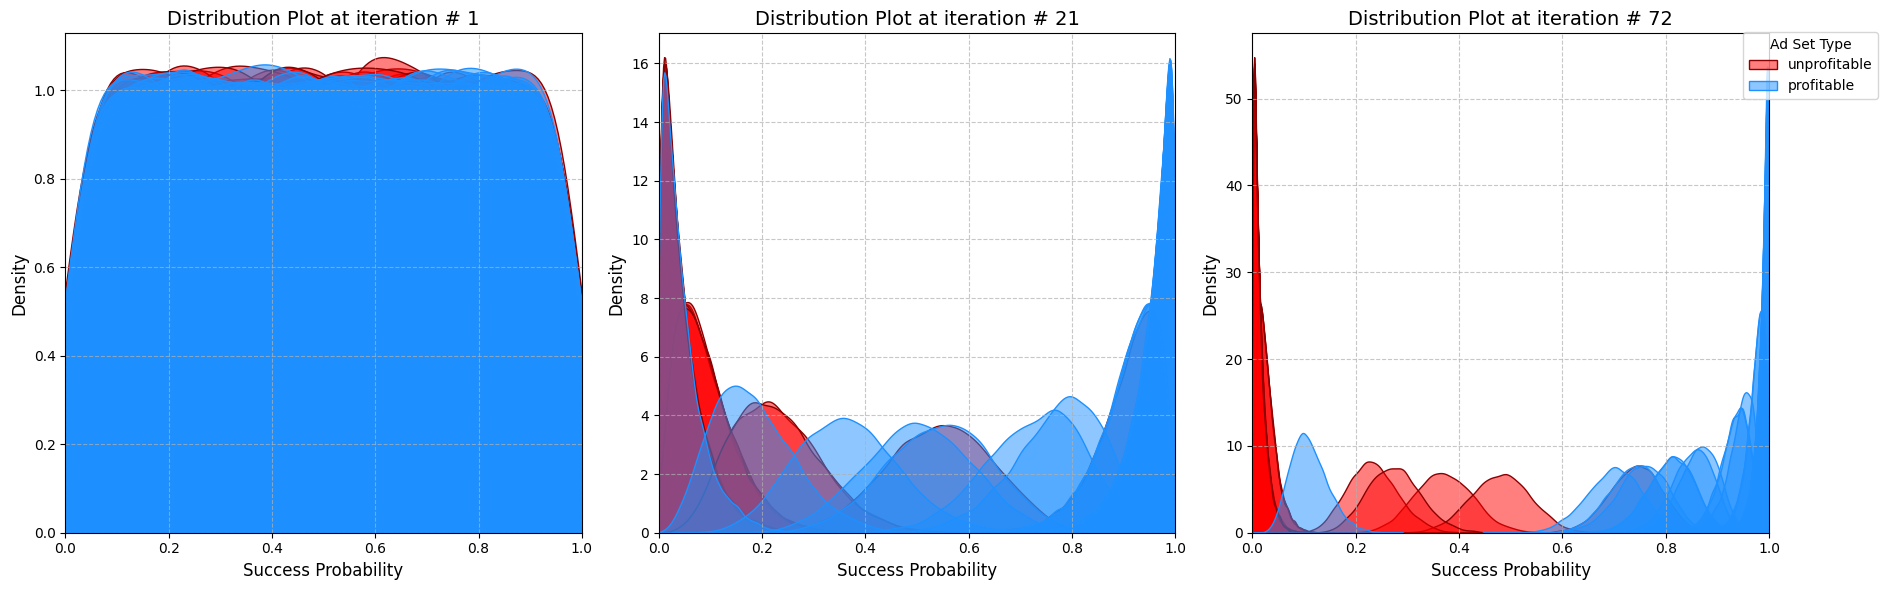

In [10]:
def plot_adset_dist_combined(history, timestamps):
    """
    Plots the distribution of success probabilities for ad sets at multiple timestamps.

    Args:
        history (dict): A dictionary containing information about ad sets at different timestamps.
                        Each key represents a timestamp, and the corresponding value is a list of ad sets.
                        Each ad set is an object containing information about its actions and success.
        timestamps (list): A list of timestamps for which the distribution plots will be generated.

    Returns:
        None
    """
    plt.figure(figsize=(18, 6))

    handles, labels = [], []

    for i, timestamp in enumerate(timestamps, 1):
        ax = plt.subplot(1, len(timestamps), i)
        plt.title(f'Distribution Plot at iteration # {timestamp+1}', fontsize=14)

        labeled = {'profitable': False, 'unprofitable': False}

        for ad in history[timestamp]:
            samples = ad.action.sample(10000)
            color = 'red' if ad._successful == 0 else "dodgerblue"
            edgecolor = 'darkred' if ad._successful == 0 else "dodgerblue"
            label = 'unprofitable' if ad._successful == 0 else 'profitable'

            if not labeled[label]:
                sns.kdeplot(samples, fill=True, color=color, edgecolor=edgecolor, label=label, alpha=0.5)
                labeled[label] = True
            else:
                sns.kdeplot(samples, fill=True, color=color, edgecolor=edgecolor, alpha=0.5)

        plt.xlabel('Success Probability', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.xlim(0, 1)
        plt.grid(True, linestyle='--', alpha=0.7)

        new_handles, new_labels = ax.get_legend_handles_labels()
        for handle, label in zip(new_handles, new_labels):
            if label not in labels:
                handles.append(handle)
                labels.append(label)

    plt.tight_layout()

    plt.figlegend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 0.95), title='Ad Set Type')

    plt.show()


# Posterior Distributions Plot
plot_adset_dist_combined(history, [0, 20, 71])

#### Score-Threshold Function Plot

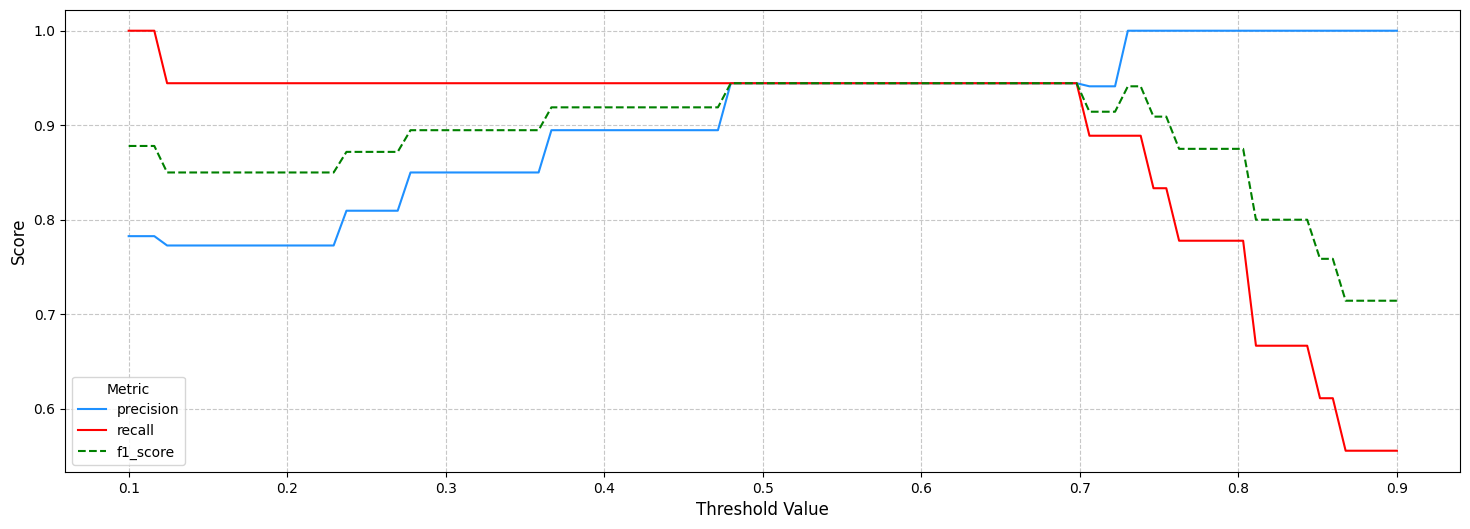

In [11]:
results = {
        "baseline": [],
        "precision": [],
        "f1_score": [],
        "recall": []
    }

# Baseline Value Estimation
for baseline in np.linspace(0.1, 0.9, 100):
    y_true = []
    y_pred = []
    for ad in adsets:
        alpha = ad.action.successes
        beta = ad.action.failures
        mu = alpha / (alpha + beta)
        value = 1 if mu > baseline else 0
        
        y_true.append(ad._successful)
        y_pred.append(value)
    
    results["baseline"].append(baseline)
    results["precision"].append(precision_score(y_true, y_pred))
    results["f1_score"].append(f1_score(y_true, y_pred))
    results["recall"].append(recall_score(y_true, y_pred))

results = pd.DataFrame(results)

# Scores Plot
plt.figure(figsize=(18, 6))
sns.lineplot(data=results, x='baseline', y='precision', label='precision', color='dodgerblue')
sns.lineplot(data=results, x='baseline', y='recall', label='recall', color='red')
sns.lineplot(data=results, x='baseline', y='f1_score', label='f1_score', color='green', linestyle="--")

plt.xlabel('Threshold Value', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Metric')
plt.show()

In [12]:
BASELINE = 0.68

#### ROC Curves Results

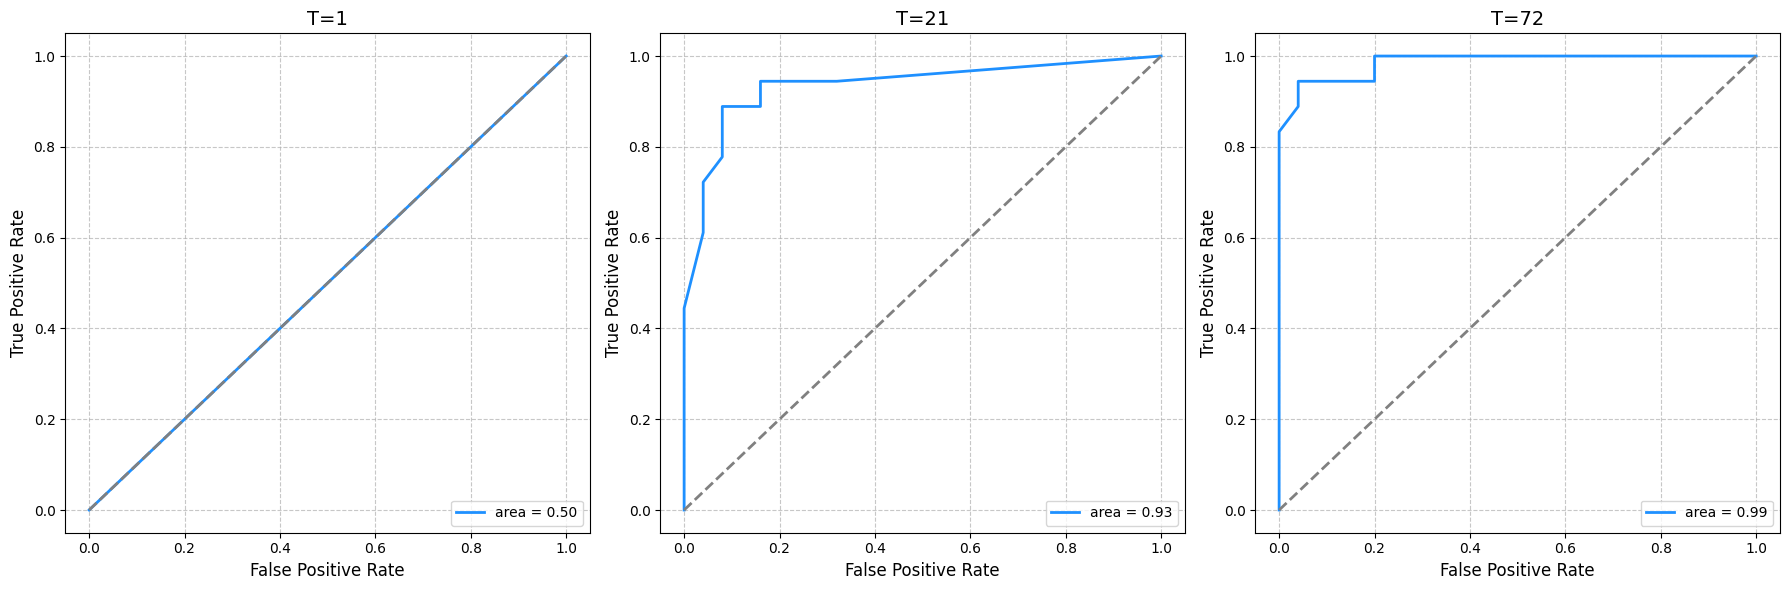

In [13]:
timestamps = [0, 20, 71]
plt.figure(figsize=(18, 6))

for i, t in enumerate(timestamps, 1):
    y_true = []
    y_scores = []

    for ad in history[t]:
        alpha = ad.action.successes
        beta = ad.action.failures
        mu = alpha / (alpha + beta)
        y_true.append(ad._successful)
        y_scores.append(mu)

    # Calculate binary predictions based on the threshold for performance metrics
    y_pred = [1 if score > BASELINE else 0 for score in y_scores]
    
    # ROC Curve calculation
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Subplot for the ROC curve
    ax = plt.subplot(1, len(timestamps), i)
    ax.plot(fpr, tpr, color='dodgerblue', lw=2, label=f'area = {roc_auc:.2f}')
    ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'T={t+1}', fontsize=14)
    ax.legend(loc="lower right")
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


100%|██████████| 3/3 [01:19<00:00, 26.41s/it]


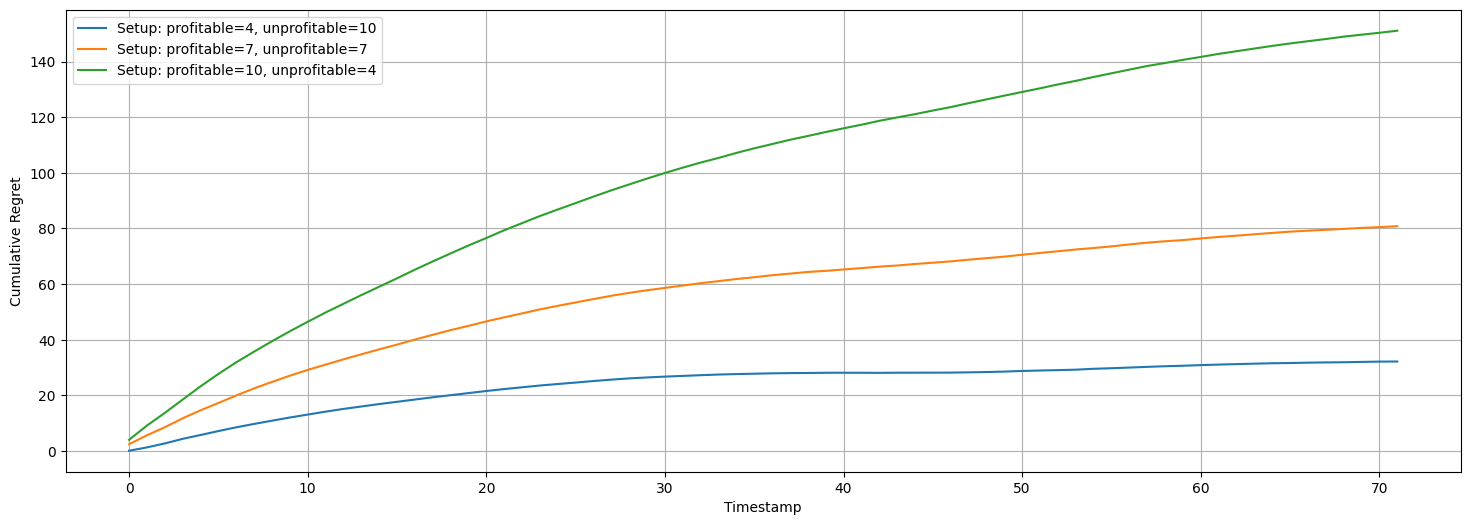

In [14]:
setups = [(4, 10), (7, 7), (10, 4)]
num_simulations = 100 

cumulative_regrets = []
for g, b in tqdm(setups):
    all_regrets = []
    for _ in range(num_simulations):
        history, adsets, regrets = simulate_ad_set_performance(data, TRAIN_INFO, max_timestamps, BASELINE, ngood=g, nbad=b)
        cumulative = pd.Series(regrets).cumsum()
        all_regrets.append(cumulative)

    # Average the regrets across simulations
    avg_cumulative_regrets = pd.concat(all_regrets, axis=1).mean(axis=1)
    cumulative_regrets.append(avg_cumulative_regrets)

# Cumulative Regret Plot
plt.figure(figsize=(18, 6))
for i, regrets in enumerate(cumulative_regrets):
    plt.plot(regrets, label=f'Setup: profitable={setups[i][0]}, unprofitable={setups[i][1]}')

plt.xlabel('Timestamp')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)
plt.show()
